# LOAN DEFAULT PREDICTION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('lending_club_loan_dataset.csv', index_col = 0)
df.head()

,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
id,,,,,,,,,,,,,,
11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [3]:
df.shape

(20000, 14)

### Dataset Feature Descriptions
The description for the features present in this dataset is -

- id - Unique ID of the loan application.
- grade - Loan grade.
- annual_inc - The annual income provided by the borrower during registration.
- short_emp - 1 when the borrower is employed for 1 year or less.
- emp_length_num - Employment length in years. It ranges between 0 and 10, where 0 means less than one year and 10 means ten or more years.
- home_ownership - Type of home ownership.
- dti - It is the Debt-To-Income Ratio that is calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s monthly income.
- purpose - A category for the loan request.
- term - The number of payments on the loan.
- last_delinq_none - 1 when the borrower had at least one event of delinquency.
- last_major_derog_none - 1 when the borrower had at least 90 days of a bad rating.
- revol_util - It is the revolving line utilization rate or the amount of credit the borrower uses relative to all available revolving credit.
- total_rec_late_fee - Late fees received to date.
- od_ratio - Overdraft ratio.
- bad_loan - 1 when a loan was not paid.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 11454641 to 6625685
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   grade                  20000 non-null  object 
 1   annual_inc             20000 non-null  float64
 2   short_emp              20000 non-null  int64  
 3   emp_length_num         20000 non-null  int64  
 4   home_ownership         18509 non-null  object 
 5   dti                    19846 non-null  float64
 6   purpose                20000 non-null  object 
 7   term                   20000 non-null  object 
 8   last_delinq_none       20000 non-null  int64  
 9   last_major_derog_none  574 non-null    float64
 10  revol_util             20000 non-null  float64
 11  total_rec_late_fee     20000 non-null  float64
 12  od_ratio               20000 non-null  float64
 13  bad_loan               20000 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 2

## DATA CLEANING AND PROFILING

In [5]:
# we first make a copy of the dataset before altering it, to preserve the original copy.
data = df.copy()
data.isnull().sum()

grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

The "last_major_derog" column has too many null values so we just drop the column.

The "home_ownership" column's null values can be filled in as another class named "None", as it may refer to people living without paying. (e.g young adults in their parents' houses)

The dti column's null values can be filled with the median value of that column.

In [6]:
data.drop(columns = ['last_major_derog_none'], inplace=True)
data['home_ownership'].fillna('None', inplace=True)
data['dti'].fillna(data['dti'].median(), inplace=True)

In [7]:
# to create a list of categorical columns
cat_cols = data.select_dtypes(include='object').columns

for col in cat_cols:
    print(col, ":", data[col].value_counts().index.tolist(), "\n")

grade : ['B', 'C', 'D', 'A', 'E', 'F', 'G'] 

home_ownership : ['MORTGAGE', 'RENT', 'OWN', 'None'] 

purpose : ['debt_consolidation', 'credit_card', 'home_improvement', 'other', 'major_purchase', 'small_business', 'medical', 'car', 'moving', 'vacation', 'house', 'wedding'] 

term : [' 36 months', ' 60 months', ' 36 Months'] 



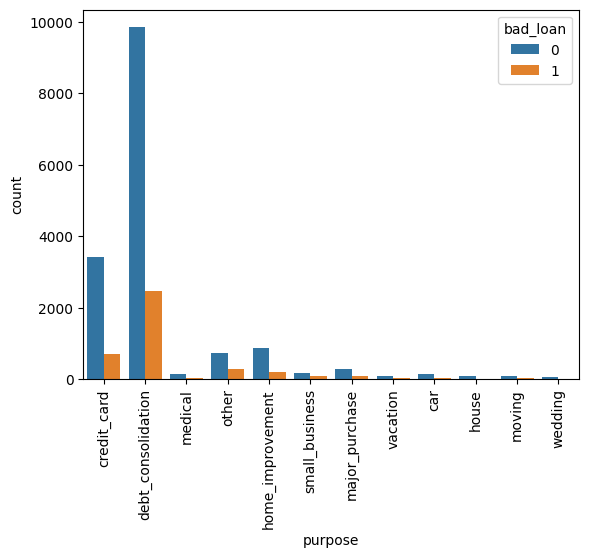

In [8]:
# let's take a look at the 'purpose' column.
sns.countplot(data=data, x = 'purpose', hue = 'bad_loan')
plt.xticks(rotation = 90);

The purpose column has too many values which is good for data exploration, but bad for modelling, as one hot encoding this feature will lead to a lot more columns. We can solve this by grouping similar columns under the same name. This will reduce from 12 possible values to 4.

The term column also has a typo which led to a new label. We can correct this

In [9]:
data.purpose.replace(['house', 'medical'], 'necessity', inplace=True)
data.purpose.replace(['home_improvement', 'car', 'wedding', 'vacation'], 'luxury', inplace=True)
data.purpose.replace(['credit_card', 'debt_consolidation'], 'debt', inplace=True)
data.purpose.replace(['moving', 'other', 'small_business'], 'major_purchase', inplace=True)

data.term.replace(' 36 Months', ' 36 months', inplace = True)

In [10]:
#setting the categorical columns as the right datatype
for col in cat_cols:
    data[col] = data[col].astype('category')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 11454641 to 6625685
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   grade               20000 non-null  category
 1   annual_inc          20000 non-null  float64 
 2   short_emp           20000 non-null  int64   
 3   emp_length_num      20000 non-null  int64   
 4   home_ownership      20000 non-null  category
 5   dti                 20000 non-null  float64 
 6   purpose             20000 non-null  category
 7   term                20000 non-null  category
 8   last_delinq_none    20000 non-null  int64   
 9   revol_util          20000 non-null  float64 
 10  total_rec_late_fee  20000 non-null  float64 
 11  od_ratio            20000 non-null  float64 
 12  bad_loan            20000 non-null  int64   
dtypes: category(4), float64(5), int64(4)
memory usage: 1.6 MB


In [11]:
data.bad_loan.value_counts()

bad_loan
0    16000
1     4000
Name: count, dtype: int64

As we can see, the dataset is very imbalanced as there are four times more instances of non-defaulters than for defaulters. This may affect the models' ability to predict the minority class (defaulters).

In [12]:
data.describe()

,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,73349.578350,0.112500,6.82140,16.584778,0.546600,55.958148,0.290622,0.504430,0.20000
std,45198.567255,0.315989,3.77423,7.556629,0.497836,42.117456,3.108654,0.287720,0.40001
min,8412.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000077,0.00000
25%,47000.000000,0.000000,3.00000,10.900000,0.000000,38.800000,0.000000,0.257356,0.00000
50%,65000.000000,0.000000,7.00000,16.190000,1.000000,57.100000,0.000000,0.506681,0.00000
75%,88000.000000,0.000000,11.00000,22.010000,1.000000,73.900000,0.000000,0.753771,0.00000
max,1000000.000000,1.000000,11.00000,34.990000,1.000000,5010.000000,96.466600,0.999894,1.00000


## EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING

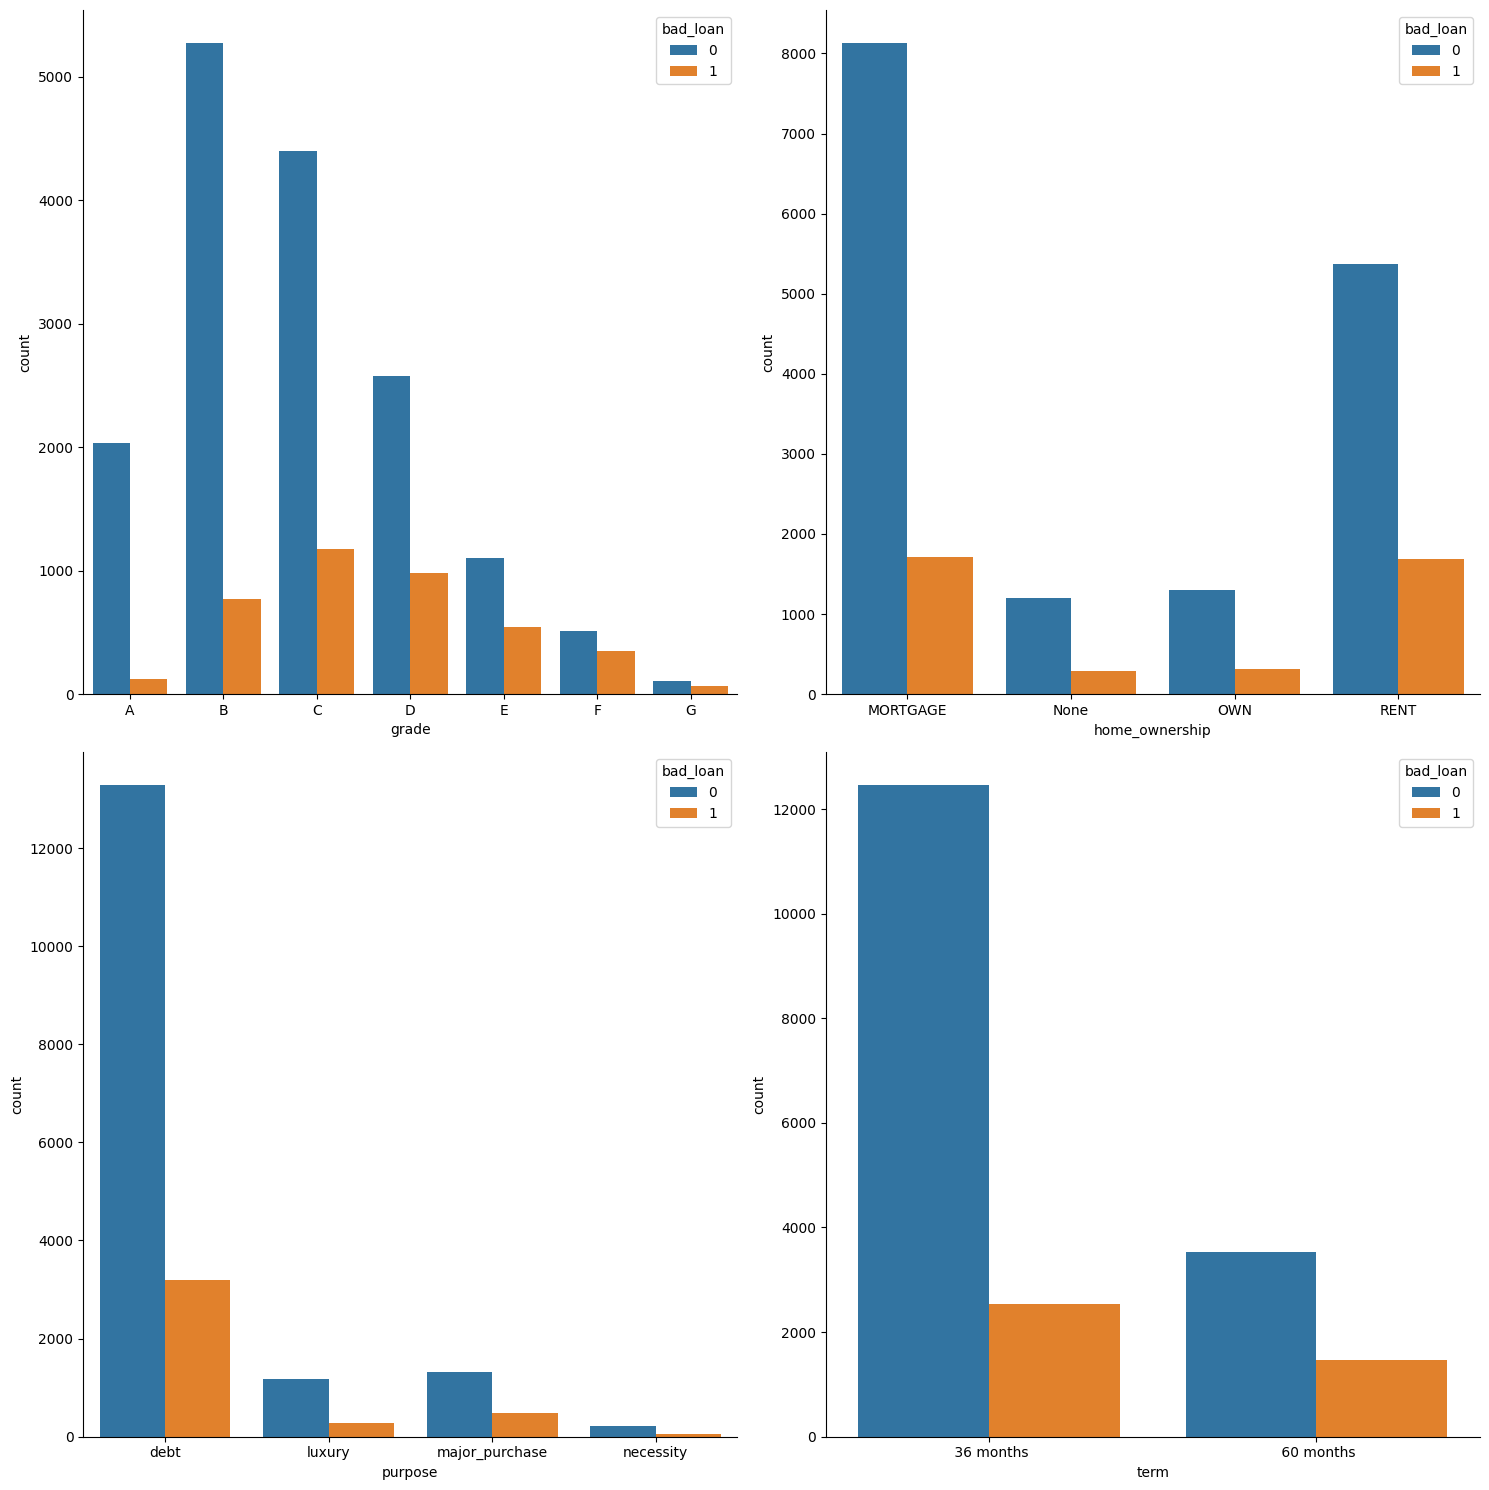

In [13]:
#to make a bar chart of the categorical features
fig, ax = plt.subplots(2,2, figsize = (15, 15))
ax = ax.flat
for i, column in enumerate(cat_cols):
    sns.countplot(data = data, x = column, hue = 'bad_loan', ax = ax[i])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
fig.subplots_adjust(top = 0.9)
fig.tight_layout()
# plt.tight_layout()
plt.show()

The above chart is very informative. A few things we can see from this is that:
- Most loans are taken to clear an existing debt (or credit card debt).
- Majority of the loans were given out for a term of 36months.
- Although B-grade loanees were the highest, most defaulters belong to the C-grade.
- Home owners people not paying for their own accommodation take loans less frequently than those paying Mortgage or Rent.

More insights can be explored from this dataset with further data exploration, but the aim of this notebook is prediction.  

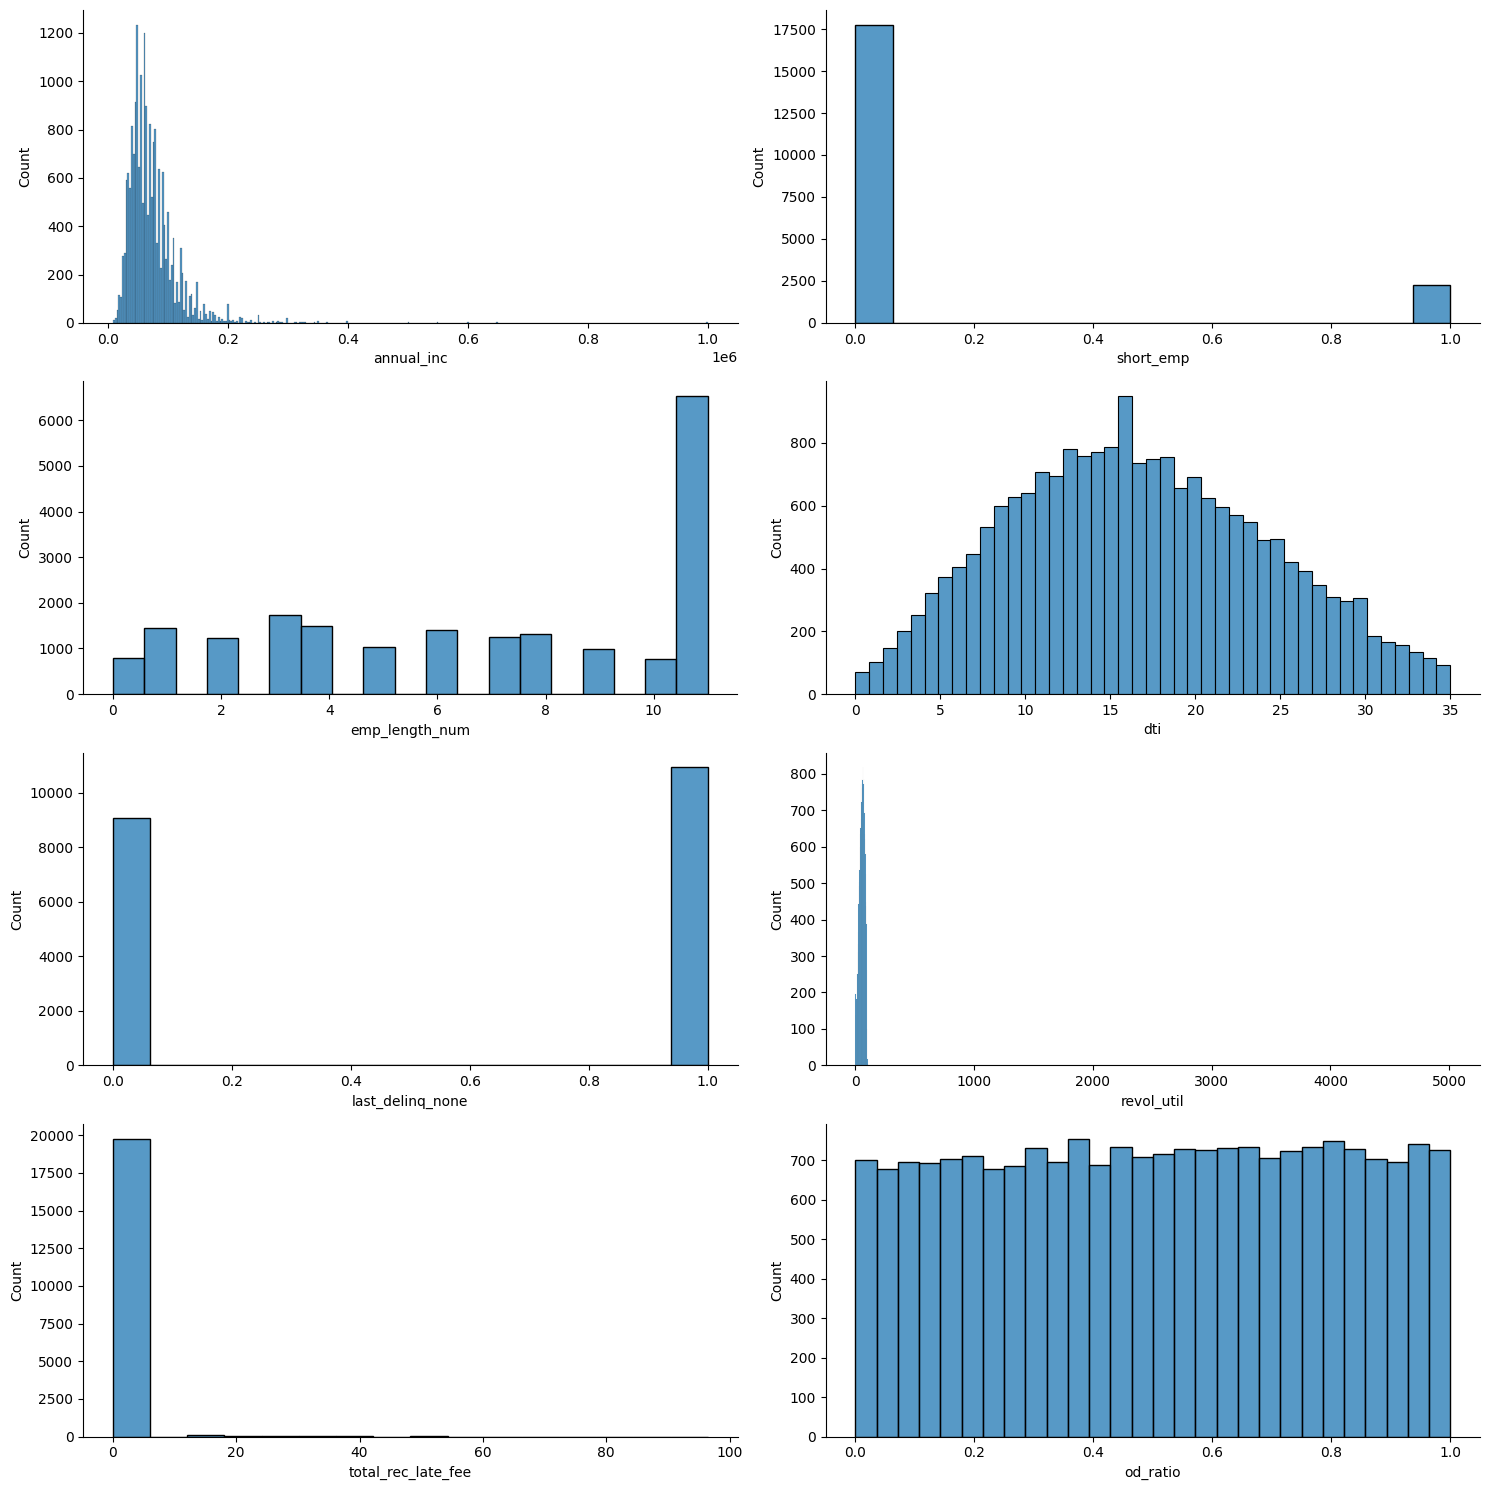

In [14]:
#to make a distribution plot for the numerical features

#we create a list of numerical features
num_cols = data.select_dtypes(include = 'number').columns.tolist()
num_cols.remove('bad_loan')

fig, ax = plt.subplots(4, 2, figsize = (15, 15))
ax = ax.flat
for i, column in enumerate(num_cols):
    sns.histplot(data = data, x = column, ax = ax[i])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
fig.subplots_adjust(top = 0.9)
fig.tight_layout()
# plt.tight_layout()
plt.show()

In [15]:
#from the above plot, the annual_inc and revol-util columns are very skewed, so we can solve this by a log transformation
print("annual_inc skewness:", data['annual_inc'].skew())
data['log_annual_inc'] = np.log(data['annual_inc'])
print("log_annual_inc skewness:", data['log_annual_inc'].skew())

print("revol_util skewness:", data['revol_util'].skew())
data['log_revol_util'] = np.log1p(data['revol_util'])
print("log_revol_util skewness:", data['log_revol_util'].skew())

annual_inc skewness: 5.276043835124063
log_annual_inc skewness: 0.23310243002994588
revol_util skewness: 81.33326407231259
log_revol_util skewness: -2.432333625913799


In [16]:
#we can drop the skewed columns as they will affect the model
data.drop(columns = ['annual_inc', "revol_util"], inplace = True)

## OUTLINE

- Get a description of all the features 
- Explore the features for duplicates and nulls
- decide what to do with the excessive nulls in the last_major_derog_none column. I suggest drop the column.
- The annual inc column is very skewed, so do a log transformation to reduce skewness. This in turn addresses outliers
- 

In [17]:
data.head()

,grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,total_rec_late_fee,od_ratio,bad_loan,log_annual_inc,log_revol_util
id,,,,,,,,,,,,,
11454641,A,1,1,RENT,26.27,debt,36 months,1,0.0,0.160624,0,11.512925,3.788725
9604874,A,0,4,OWN,5.39,debt,36 months,0,0.0,0.810777,0,11.326596,3.113515
9684700,D,0,11,MORTGAGE,18.45,debt,60 months,1,0.0,0.035147,1,11.264464,3.856510
9695736,D,0,6,MORTGAGE,12.28,necessity,60 months,0,0.0,0.534887,1,10.533056,2.459589
9795013,D,0,11,MORTGAGE,11.26,debt,36 months,0,0.0,0.166500,0,11.082143,2.785011


In [18]:
#this cell is for one hot encoding of the columns
data['term'] = data['term'].replace({' 36 months': 0, ' 60 months': 1}).astype('int')
# data['grade'] = data['grade'].replace(data.grade.value_counts(sort = False).index.tolist(), np.arange(1, 8)).astype('int')

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
encode_cols = ['home_ownership', 'purpose', 'grade']
one_hot_encoded = ohe.fit_transform(data[encode_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns = ohe.get_feature_names_out(encode_cols), index = data.index)

data_encoded = pd.concat([data, one_hot_df], axis = 1)
data_encoded.drop(encode_cols, axis = 1, inplace= True)
data_encoded.head()

,short_emp,emp_length_num,dti,term,last_delinq_none,total_rec_late_fee,od_ratio,bad_loan,log_annual_inc,log_revol_util,...,purpose_luxury,purpose_major_purchase,purpose_necessity,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
id,,,,,,,,,,,,,,,,,,,,,
11454641,1,1,26.27,0,1,0.0,0.160624,0,11.512925,3.788725,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9604874,0,4,5.39,0,0,0.0,0.810777,0,11.326596,3.113515,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9684700,0,11,18.45,1,1,0.0,0.035147,1,11.264464,3.856510,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9695736,0,6,12.28,1,0,0.0,0.534887,1,10.533056,2.459589,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9795013,0,11,11.26,0,0,0.0,0.166500,0,11.082143,2.785011,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
X = data_encoded.drop(columns = 'bad_loan')
Y = data_encoded.bad_loan

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
x_, x_test, y_, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size = 0.25, random_state=0)
print("x_train shape: {0}, x_val shape: {1}, x_test shape: {2}".format(x_train.shape, x_test.shape, x_val.shape))
print("\nBefore resampling:", y_train.value_counts())


#applying SMOTE to provide more samples of the minority class, and undersampling to provide less of majority class
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy = 0.7)
under = RandomUnderSampler(sampling_strategy = 0.9)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps = steps)
x_train, y_train = pipeline.fit_resample(x_train, y_train)
print("\nAfter resampling: ", y_train.value_counts())

x_train shape: (12000, 24), x_val shape: (4000, 24), x_test shape: (4000, 24)

Before resampling: bad_loan
0    9592
1    2408
Name: count, dtype: int64

After resampling:  bad_loan
0    7460
1    6714
Name: count, dtype: int64


## MODELLING

In [21]:
#importing the metrics and creating a method for plotting the confusion matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_conf(y_actual, prediction):
    conf_matrix = confusion_matrix(y_actual, prediction)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=[0, 1])
    cm_display.plot()
    plt.show()
    print(classification_report(y_actual, prediction))

In [22]:
#defining the baseline metrics. The model is said to be effective if its performance exceeds that of the baseline model
from sklearn.dummy import DummyClassifier 
dummy = DummyClassifier(strategy = 'most_frequent').fit(x_train, y_train)
dummy_pred = dummy.predict(x_test)
print("The baseline model auc is {}".format(roc_auc_score(y_test, dummy_pred)))

The baseline model auc is 0.5


### A. ENSEMBLE TREES

In [23]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

#create the xgb_model
xgb_model = xgb.XGBClassifier(eval_metric = f1_score, objective = 'binary:logistic', random_state = 0, n_estimators = 300, 
                              scale_pos_weight = 5, colsample_bytree = 0.5, max_depth = 5)
xgb_model.fit(x_train, y_train)

pred_val = xgb_model.predict(x_val)
pred_train = xgb_model.predict(x_train)
print("Validation F1_score:", f1_score(y_val, pred_val))
print("Train F1_score:", f1_score(y_train, pred_train))


Validation F1_score: 0.37129596572652623
Train F1_score: 0.8651997160740788


In [24]:
# %%time
# from sklearn.model_selection import RandomizedSearchCV
# param_distribution = {
#     'gamma': [0.01, 0.05, 5],
#     'max_depth': [10, 20, 30], 
#     'learning_rate': [0.01, 0.1, 0.5]
# }
# random_search = RandomizedSearchCV(xgb_model, param_distributions = param_distribution, scoring = 'recall', cv = 5, n_iter = 5, n_jobs = 3)
# random_search.fit(x_train, y_train)
# random_search.best_params_

In [25]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold

In [26]:
# cv = StratifiedKFold(n_splits = 5)
# visualizer = LearningCurve(xgb_model, cv = cv, train_sizes = np.linspace(0.3, 1.0, 10), n_jobs = 4, scoring='f1')
# visualizer.fit(x_train, y_train)
# visualizer.show()

In [27]:
# k = np.arange(2, 10)
# performance_scores = [np.mean(cross_val_score(xgb_model, x_, y_, cv=StratifiedKFold(n_splits=i, shuffle=True), scoring='roc_auc')) for i in k]
# best_k = k[np.argmax(performance_scores)]
# plt.plot(k, performance_scores, marker = 'o', color = 'r')
# plt.title('Plot of performance scores vs validation folds');

### B. NEURAL NETWORK

In [28]:
#packages for creating neural network
import tensorflow as tf
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

#package for normalization of data
from sklearn.preprocessing import MinMaxScaler

In [43]:
# Scaler the data 
scaler = MinMaxScaler()
scaler.fit(x_)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

In [30]:
neural = Sequential([
    Input(shape = (24,)),
    Dense(units = 24, activation = 'relu', name = 'L1'),
    Dense(units= 24, activation = 'relu', name = 'L2'),
    Dense(units = 1, activation = 'sigmoid', kernel_regularizer = tf.keras.regularizers.L2(0.001), name = 'L3')
], name = 'neural')
neural.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = tf.keras.losses.BinaryCrossentropy())

history = neural.fit(x_train_norm, y_train, epochs = 40)

Epoch 1/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6489
Epoch 2/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6130
Epoch 3/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6089
Epoch 4/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5902
Epoch 5/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5859
Epoch 6/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5740
Epoch 7/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5626
Epoch 8/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5605
Epoch 9/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5554
Epoch 10/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5449
Epoch 11/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5400
Epoch 12/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5402
Epoch 13/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5367
Epoch 14/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5363
Epoch 15/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [31]:
x_val_norm = scaler.transform(x_val)
pred_neural_val = neural.predict(x_val_norm)
pre_val = pred_neural_val.reshape(-1)>0.5
pred_neural_train = neural.predict(x_train_norm)
pre_train = pred_neural_train.reshape(-1)>0.5

print("Validation F1_score:", f1_score(y_val, pre_val))
print("Train F1_score:", f1_score(y_train, pre_train))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation F1_score: 0.37108433734939755
Train F1_score: 0.6834538352862961


### C. LOGISTIC REGRESSION

In [32]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty = 'l2', C =2.0)
lr_model.fit(x_train_norm, y_train)
lr_prob_val = pd.Series(lr_model.predict_proba(x_val_norm)[:,1])

In [33]:
# using randomized search to get the best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

lr_model = LogisticRegression()
param_distribution = {'C': [0.1, 0.5, 1, 1.5, 2], 
                     'penalty':['l2', 'l1']}
rsearch = RandomizedSearchCV(estimator = lr_model, param_distributions = param_distribution,
                            scoring ='f1', cv = 5, n_jobs = 3, n_iter = 5)
rsearch.fit(x_train_norm, y_train)
rsearch.best_params_, rsearch.best_score_, rsearch.scorer_

({'penalty': 'l2', 'C': 1},
 0.629558542199186,
 make_scorer(f1_score, average=binary))

0.5000000000000001
0.4159519725557461


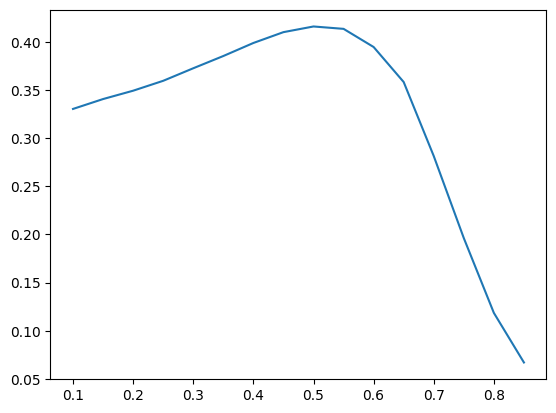

In [34]:
#to tune the probability cutoff for the optimal model performance
def tune_proba(proba, threshold):
    if proba > threshold:
        return 1
    else: return 0

scores = [f1_score(y_val, lr_prob_val.apply(tune_proba, args = (a,))) for a in np.arange(0.1, 0.9, 0.05)]

plt.plot(np.arange(0.1, 0.9, 0.05), scores)
print(np.arange(0.1, 0.9, 0.05)[np.argmax(scores)])
print(max(scores))

### D. RANDOM FOREST CLASSIFIER

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 180, min_samples_leaf = 1, random_state = 0)
rf.fit(x_train, y_train)
rf_pred_val = rf.predict(x_val)
rf_pred_train = rf.predict(x_train)
print("Validation F1_score:", f1_score(y_val, rf_pred_val))
print("Train F1_score:", f1_score(y_train, rf_pred_train))

Validation F1_score: 0.32854209445585214
Train F1_score: 1.0


### FEATURE SELECTION

<Axes: >

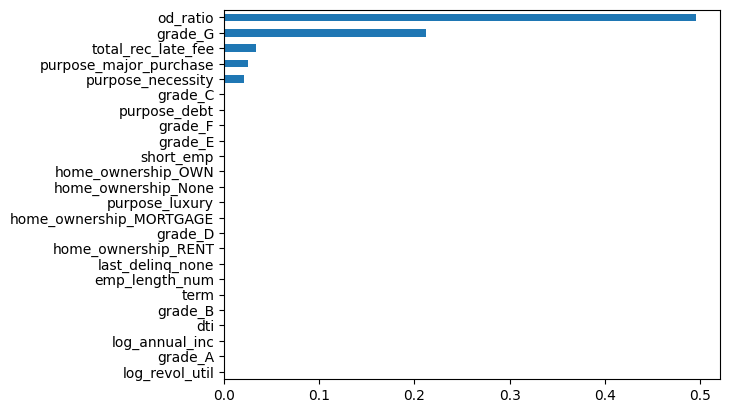

In [36]:
from scipy.stats import chi2_contingency
# to obtain the p-values from chi-squared test on features with target variable.
pvalues = [chi2_contingency(pd.crosstab(index = x_train[i], columns = y_train)).pvalue for i in x_train.columns]

pd.Series(pvalues, index = x_train.columns).sort_values(ascending = True).plot(kind = 'barh')

In [37]:
# extracting only the top 4 features to reduce noise in the dataset
most_import = pd.Series(pvalues, index=x_train.columns).sort_values(ascending = True)[:4].index
# converting the arrays to dataframe objects
x_train_norm = pd.DataFrame(x_train_norm, columns = x_train.columns)
x_val_norm = pd.DataFrame(x_val_norm, columns = x_train.columns)
x_train_norm.head()

,short_emp,emp_length_num,dti,term,last_delinq_none,total_rec_late_fee,od_ratio,log_annual_inc,log_revol_util,home_ownership_MORTGAGE,...,purpose_luxury,purpose_major_purchase,purpose_necessity,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0.0,1.000000,0.190626,0.0,0.0,0.0,0.977497,0.400451,0.442303,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.181818,0.866247,0.0,0.0,0.0,0.317296,0.419394,0.427900,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.090909,0.161189,0.0,0.0,0.0,0.759112,0.373028,0.470164,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.272727,0.250643,0.0,1.0,0.0,0.714850,0.236169,0.480591,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.272727,0.512432,1.0,1.0,0.0,0.363829,0.499340,0.472073,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
# training a logistic regression model on only these top 4 features
lr_model2 = LogisticRegression()
lr_model2.fit(x_train_norm[most_import], y_train)
f1_score(y_val, lr_model2.predict(x_val_norm[most_import]))

0.38620689655172413

In [39]:
def data_optimizer(models):
    '''To get the optimal number of features for the model'''
    n_plots = len(models)
    n_cols = 2
    n_rows = (n_plots+1)//n_cols
    fig,ax = plt.subplots(n_rows, n_cols, figsize = ([15, 10]))
    for j, model in enumerate(models):
        ax = plt.subplot(n_rows, n_cols, j+1)
        f1_scores = []
        f1_scores_train =[]
        n = np.arange(1, len(x_train.columns))
        for i in n:
            most_import = pd.Series(pvalues, index=x_train.columns).sort_values(ascending = True)[:i].index
            X_train = x_train_norm[most_import]
            X_val = x_val_norm[most_import]

            model.fit(X_train, y_train)
            pred_vall = model.predict(X_val)
            pred_trainn = model.predict(X_train)
            f1_scores_train.append(f1_score(y_train, pred_trainn))
            f1_scores.append(f1_score(y_val, pred_vall))

        plt.plot(n, f1_scores, marker = 'o', color = 'r', label= 'Validation scores')
        plt.plot(n, f1_scores_train, marker = 'o', color = 'g', label = 'Train scores')
        plt.ylabel('F1 score')
        plt.xlabel('Number of features')
        plt.legend()
        plt.title(type(model).__name__)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        print("Model: {}\nThe optimal number of features is {} with an F1-score of {} on the validation set.\n".format(type(model).__name__, n[np.argmax(f1_scores)], max(f1_scores)))
    fig.subplots_adjust(top = 0.9)
    fig.tight_layout()

In [40]:
xgb_2 = xgb.XGBClassifier(tree_method = 'hist', enable_categorical = True, eval_metric = f1_score, 
                                      objective = 'binary:logistic', n_estimators = 100, 
                                      random_state = 0, colsample_bytree = 0.5, max_depth = 5, scale_pos_weight = 5)

Model: SVC
The optimal number of features is 7 with an F1-score of 0.4050632911392405 on the validation set.

Model: MultinomialNB
The optimal number of features is 23 with an F1-score of 0.38593687574910107 on the validation set.

Model: LogisticRegression
The optimal number of features is 22 with an F1-score of 0.4183062446535501 on the validation set.

Model: XGBClassifier
The optimal number of features is 21 with an F1-score of 0.3718211049400759 on the validation set.



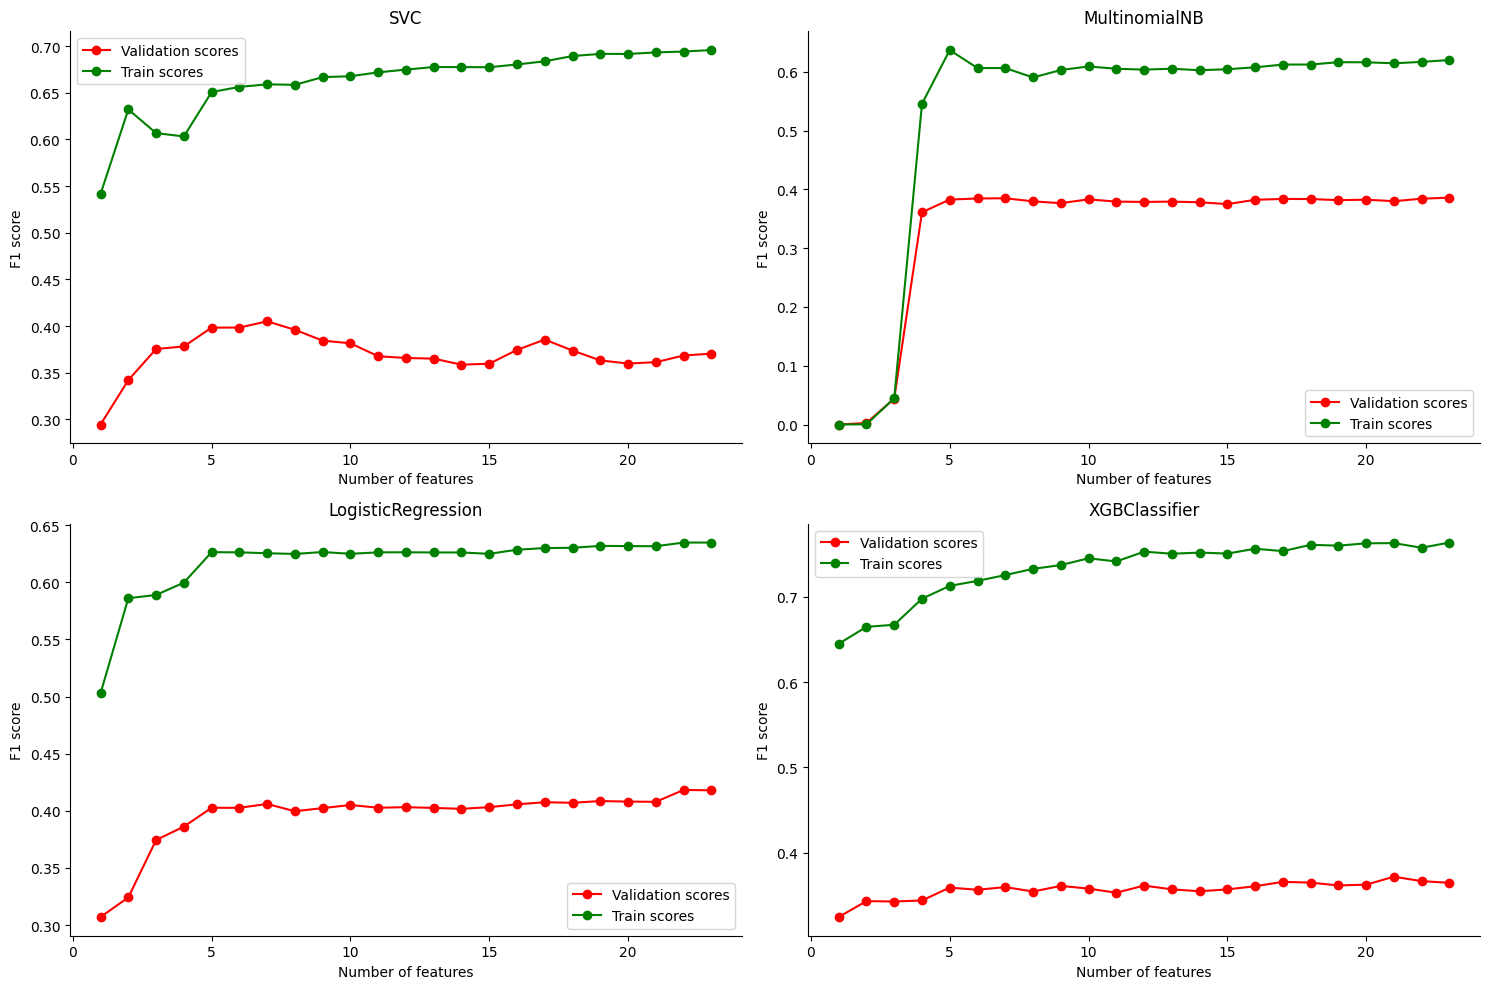

In [41]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

svc = SVC(kernel = 'rbf')
lr_model = LogisticRegression(penalty = 'l2', C =1.0)
nb_clf = MultinomialNB()

models = [svc, nb_clf, lr_model, xgb_2]
data_optimizer(models)

The ensemble models are overfitting because there is no correlation between the features and the target variable, so it just memorizes the observations. The logistic regression and Multinomial Naive Bayes also perform poorly on the validation set.

The best F1-score achieved is 0.42 with the Logistic Regresion model.

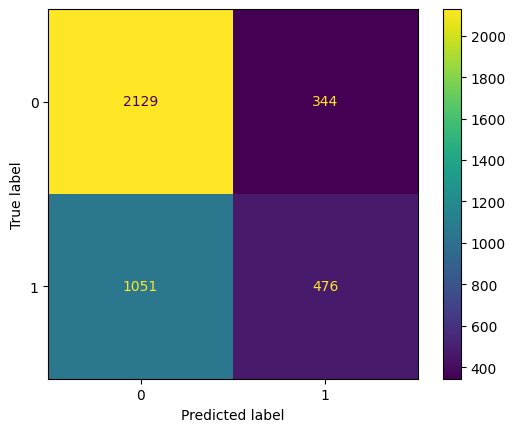

              precision    recall  f1-score   support

           0       0.67      0.86      0.75      2473
           1       0.58      0.31      0.41      1527

    accuracy                           0.65      4000
   macro avg       0.62      0.59      0.58      4000
weighted avg       0.64      0.65      0.62      4000



In [44]:
lr_model = LogisticRegression(penalty = 'l2', C =2.0)
lr_model.fit(x_train_norm, y_train)
prediction = lr_model.predict(x_test_norm)
plot_conf(prediction, y_test)